In [1]:
import json
import random
import os
import pandas as pd
from sklearn.model_selection import train_test_split


from utils.data2seq import Dial2seq, SequencePreprocessor

# Data preprocessing (skip if preprocessed)

In [2]:
# topical_sequencer = Dial2seq('data/topical_chat_annotated.json', 3)
daily_sequencer = Dial2seq('data/daily_dialogue_annotated.json', 3)
daily_seqs = daily_sequencer.transform()
print('Total number of sequences in the DailyDialog dataset is', len(daily_seqs))
topical_sequencer = Dial2seq('data/topical_chat_annotated.json', 3)
topical_seqs = topical_sequencer.transform()
print('Total number of sequences in the Topical Chat dataset is', len(topical_seqs))

Total number of sequences in the DailyDialog dataset is 61087
Total number of sequences in the Topical Chat dataset is 162494


In [3]:
preproc = SequencePreprocessor()
midas_dataset = preproc.transform(daily_seqs + topical_seqs)
len(midas_dataset)

223581

In [4]:
train, val_test = train_test_split(midas_dataset, test_size=0.2, random_state=42)
val, test = train_test_split(val_test, test_size=0.5, random_state=42)

#### stats for train/val/test

In [5]:
target_train = [sample['predict'] for sample in train]
target_val = [sample['predict'] for sample in val]
target_test = [sample['predict'] for sample in test]

In [7]:
target_train = pd.json_normalize(target_train)
target_val = pd.json_normalize(target_val)
target_test = pd.json_normalize(target_test)

validate all midas labels from test and val are in train

In [9]:
set(target_val['midas'].value_counts().index.tolist()) -set(target_train['midas'].value_counts().index.tolist())

set()

In [10]:
set(target_test['midas'].value_counts().index.tolist()) - set(target_train['midas'].value_counts().index.tolist())

set()

In [11]:
target_train['midas'].value_counts(normalize=True)

opinion                  0.320344
statement                0.278278
pos_answer               0.117285
comment                  0.101395
yes_no_question          0.042105
neg_answer               0.031812
appreciation             0.026624
open_question_factual    0.021514
complaint                0.021228
command                  0.016521
open_question_opinion    0.012982
other_answers            0.008062
dev_command              0.001851
Name: midas, dtype: float64

In [12]:
target_val['midas'].value_counts(normalize=True)

opinion                  0.314026
statement                0.284104
pos_answer               0.115350
comment                  0.102648
yes_no_question          0.040925
neg_answer               0.032159
appreciation             0.028625
open_question_factual    0.021603
complaint                0.021558
command                  0.016594
open_question_opinion    0.011897
other_answers            0.008811
dev_command              0.001700
Name: midas, dtype: float64

In [13]:
target_test['midas'].value_counts(normalize=True)

opinion                  0.315041
statement                0.283957
pos_answer               0.115792
comment                  0.100720
yes_no_question          0.041191
neg_answer               0.033499
appreciation             0.026790
complaint                0.021602
open_question_factual    0.021200
command                  0.017711
open_question_opinion    0.013060
other_answers            0.008274
dev_command              0.001163
Name: midas, dtype: float64

In [14]:
with open('data/annotated/midas_train.json', 'w', encoding='utf-8') as f:
    json.dump(train, f, ensure_ascii=False, indent=2)
    
with open('data/annotated/midas_val.json', 'w', encoding='utf-8') as f:
    json.dump(val, f, ensure_ascii=False, indent=2)
    
with open('data/annotated/midas_test.json', 'w', encoding='utf-8') as f:
    json.dump(test, f, ensure_ascii=False, indent=2)

# Load Data and models

### Data

In [2]:
Midas2Id = {
    "appreciation": 0, "command": 1, "comment": 2,"complaint": 3,
    "dev_command": 4, "neg_answer": 5, "open_question_factual": 6,
    "open_question_opinion": 7, "opinion": 8, "other_answers": 9,
    "pos_answer": 10, "statement": 11, "yes_no_question": 12,
}

In [3]:
with open('data/annotated/midas_train.json', 'r', encoding='utf8') as f:
    train = json.load(f)
    
with open('data/annotated/midas_val.json', 'r', encoding='utf8') as f:
    val = json.load(f)

with open('data/annotated/midas_test.json', 'r', encoding='utf8') as f:
    test = json.load(f)

In [5]:
len(train), len(val), len(test)

(178864, 22358, 22359)

### Models

In [6]:
import pickle

from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import tensorflow_hub as hub

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from utils.midas_dataset import MidasDataset, MidasVectorizer

In [7]:
os.environ['TFHUB_CACHE_DIR'] = './models/tf_cache'
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
encoder = hub.load(module_url)
print ("module %s loaded" % module_url)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [8]:
midas_vectorizer = MidasVectorizer(
    text_vectorizer=encoder, # USE
    midas2id=Midas2Id,
    context_len=3,
    embed_dim=512 # USE vector size
)

In [9]:
midas_vectorizer.context_vector(train[0]['previous_text'], train[0]['midas_vectors'])

array([-0.01867618, -0.10222048, -0.07162994, ...,  0.05140803,
        0.86425042,  0.03094536])

In [10]:
train_dataloader = MidasDataset(
    data=train,
    vectorizer=midas_vectorizer,
    batch_size= len(train),
    shuffle=False)

val_dataloader = MidasDataset(
    data=val,
    vectorizer=midas_vectorizer,
    batch_size= len(val),
    shuffle=False)

test_dataloader = MidasDataset(
    data=test,
    vectorizer=midas_vectorizer,
    batch_size= len(test),
    shuffle=False)

In [11]:
for X_train, y_train in train_dataloader:
    break

In [12]:
X_train.shape, len(y_train)

((178864, 1575), 178864)

In [13]:
for X_val, y_val in val_dataloader:
    break

In [14]:
X_val.shape, len(y_val)

((22358, 1575), 22358)

In [15]:
for X_test, y_test in test_dataloader:
    break

In [16]:
X_test.shape, len(y_test)

((22359, 1575), 22359)

### train and eval

In [266]:
rfc_model = RandomForestClassifier(max_depth=20, max_samples=0.60, random_state=42)

In [267]:
rfc_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, max_samples=0.6, random_state=42)

In [268]:
val_preds = rfc_model.predict(X_val)

In [269]:
Counter(val_preds)

Counter({8: 14870,
         6: 44,
         11: 7070,
         10: 151,
         3: 28,
         7: 11,
         2: 66,
         12: 56,
         1: 27,
         5: 22,
         0: 7,
         9: 3,
         4: 3})

In [270]:
accuracy_score(y_val, val_preds)

0.40459790678951607

In [271]:
f1_score(y_val, val_preds, average='weighted')

0.3192996037601866

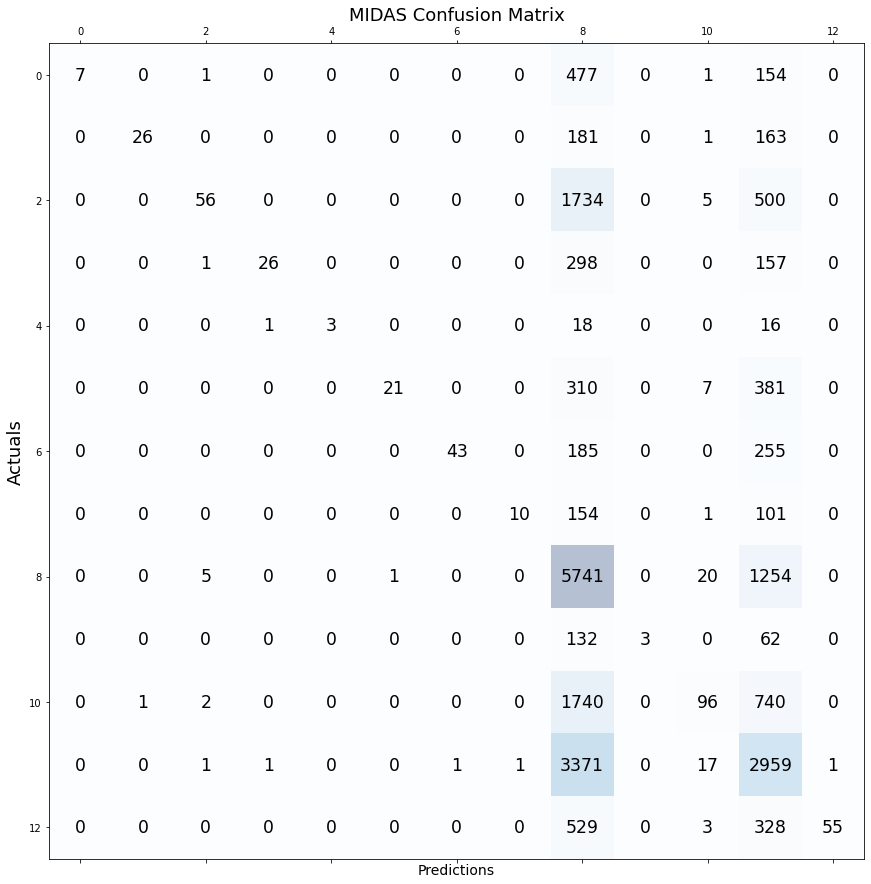

In [272]:
conf_matrix = confusion_matrix(
    [list(Midas2Id)[i] for i in y_val],
    [list(Midas2Id)[i] for i in val_preds],
    labels=list(Midas2Id))

fig, ax = plt.subplots(figsize=(15, 15))

ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=14)
plt.ylabel('Actuals', fontsize=18)
plt.title('MIDAS Confusion Matrix', fontsize=18)
plt.show()

In [273]:
# Store data (serialize)
with open('models/rfc_depth20_maxsample06.pickle', 'wb') as f:
    pickle.dump(rfc_model, f, protocol=pickle.HIGHEST_PROTOCOL)

In [54]:
# Load data (deserialize)
with open('models/rfc_depth20.pickle', 'rb') as f:
    loaded_model = pickle.load(f)

### Inference

In [ ]:
midas_vectorizer = MidasVectorizer(
    text_vectorizer=encoder, # USE
    midas2id=Midas2Id,
    context_len=3,
    embed_dim=512 # USE vector size
)

In [128]:
def inference(context: list, midas: list, clf, vectorizer) -> np.ndarray:
    """
    context: list of utterances (string)
    midas: list of lists of midas dicts {midas_label_1: prob, ..., midas_label_n, proba}
            1D : number of utterances = 3, 2D: number of sentences in the utterance: N
    clf: sklearn classifier trained to predict next midas label
    vectorizer: Vectorizer to concatenate text embeddings with midas proba distribution
    
    output: probability distribution for the next utterance
    """
    # extract vectors
    midas_vectors = list()

    for ut in test_midas:
        utterance_vec = list()
        for sent in ut:
            utterance_vec.append(list(sent.values()))
        midas_vectors.append(utterance_vec)

    assert len(context) == len(midas_vectors)
    vec = vectorizer.context_vector(context, midas_vectors)[None, :]
    
    pred_probas = clf.predict_proba(vec)
    
    return pred_probas.squeeze()

test on a dummy data

In [129]:
test_context = [" ".join(ut) for ut in train[13]['previous_text']]

test_midas = list()
for ut in train[13]['midas_vectors']:
    ut_midas = list()
    for sent in ut:
        ut_midas.append(dict(zip(Midas2Id, sent)))
    test_midas.append(ut_midas)
    
for text, ut in zip(test_context, test_midas):
    print(text)    
    print('Utterance len: ', len(ut))    
    print(ut, '\n')

Yeah I think the original is going to be the best. Did you know that Stephen King actually thinks that the movie Bambi should be a horror movie?
Utterance len:  2
[{'appreciation': 0.0022430846001952887, 'command': 0.0024833311326801777, 'comment': 0.007560018915683031, 'complaint': 0.0010543332900851965, 'dev_command': 0.001281813019886613, 'neg_answer': 0.0013224049471318722, 'open_question_factual': 0.0015646334504708648, 'open_question_opinion': 0.0012719057267531753, 'opinion': 0.9702610373497009, 'other_answers': 0.0010310874786227942, 'pos_answer': 0.0032127194572240114, 'statement': 0.005328143946826458, 'yes_no_question': 0.001385452225804329}, {'appreciation': 0.01672188937664032, 'command': 0.08160554617643356, 'comment': 0.020263012498617172, 'complaint': 0.0159416776150465, 'dev_command': 0.05004351958632469, 'neg_answer': 0.0061445110477507114, 'open_question_factual': 0.011150079779326916, 'open_question_opinion': 0.012583243660628796, 'opinion': 0.020224809646606445, 'o

In [145]:
np.argmax(inference(test_context, test_midas, rfc_model, midas_vectorizer), axis=-1)

11

In [133]:
np.argmax(inference(test_context, test_midas, loaded_model, midas_vectorizer), axis=-1)

8

## GridSearchCV

In [17]:
from sklearn.model_selection import GridSearchCV

In [37]:
rfc = RandomForestClassifier()

In [38]:
forest_params = [{
    'max_depth': list(range(5, 35, 5)), 
    'n_estimators': list(range(20,100,20)),
    'criterion' : ["gini", "entropy"],
    'min_samples_split': list(range(2,5)),
    'random_state': [42],
    'max_samples': [x / 10.0 for x in range(2, 12, 2)],
    'class_weight': ['balanced', "balanced_subsample", None]
}]

In [40]:
clf = GridSearchCV(rfc, forest_params, scoring='accuracy')

clf.fit(X_train, y_train)

c:\users\denis\documents\hse\deeppavlov\autoskill\venv\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid=[{'class_weight': ['balanced', 'balanced_subsample',
                                           None],
                          'criterion': ['gini', 'entropy'],
                          'max_depth': [5, 10, 15, 20, 25, 30],
                          'max_samples': [0.2, 0.4, 0.6, 0.8, 1.0],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [20, 40, 60, 80],
                          'random_state': [42]}],
             scoring='accuracy')

In [32]:
forest_params

[{'max_depth': [5, 10, 15, 20, 25, 30],
  'n_estimators': [20, 40, 60, 80],
  'criterion': ['gini', 'entropy'],
  'min_samples_split': [2, 3, 4],
  'random_state': 42,
  'max_samples': [0.2, 0.4, 0.6, 0.8, 1.0],
  'class_weight': ['balanced', 'balanced_subsample', None]}]

In [41]:
clf.best_estimator_

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=10, max_samples=0.4, n_estimators=60,
                       random_state=42)